<a href="https://colab.research.google.com/github/safwanp314/cari-net/blob/master/munit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
!pip install tensorflow-addons

In [0]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow_addons.layers import InstanceNormalization, GroupNormalization
from tensorflow.keras.activations import relu
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.applications import  VGG19
import tensorflow.keras.backend as K

In [0]:
import os
import sys
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# Architecture configs
IMAGE_SHAPE = (128, 128, 3)

# number of input channels of generators
nc_in = 3

# style latent dim
n_dim_style = 16

# number of residual blocks in decoder and content encoder
n_resblocks = 3

# number of adain dim
n_dim_adain = 64

# number of noise dim
n_dim_noise = 128

# number of channels of the first conv2d of encoder
nc_base = 64

# number of style encoder dowscaling
n_dowscale_style = 4

# number of content encoder dowscaling
n_downscale_content = 2

# use group norm or layer norm
use_groupnorm=True

# batch size
batch_size = 1

In [0]:
vgg = VGG19(include_top=True, weights='imagenet')
vgg.trainable = False

def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  outputs = [vgg.get_layer(name).output for name in layer_names]
  model = tf.keras.Model([vgg.input], outputs)
  return model

# Content layer where will pull our feature maps
content_layers = ['block5_conv3']
content_extractor = vgg_layers(content_layers)

In [0]:
##################################################################################
# Basic Blocks
##################################################################################
def conv_block(input_tensor, f, k=3, strides=2, use_norm=False):
    x = input_tensor
    x = ReflectPadding2D(x)
    x = Conv2D(f, kernel_size=k, strides=strides, kernel_initializer='he_normal',
               kernel_regularizer=l2(1e-4),
               use_bias=(not use_norm), padding='valid')(x)
    if use_norm:
        x = InstanceNormalization(epsilon=1e-5)(x)
    x = Activation('relu')(x)
    return x

def upscale_nn(inp, f, use_norm=False):
    x = inp
    x = UpSampling2D()(x)
    x = ReflectPadding2D(x, 2)
    x = Conv2D(f, kernel_size=5, kernel_initializer='he_normal', 
               kernel_regularizer=l2(1e-4), 
               use_bias=(not use_norm), padding='valid')(x)
    if use_norm:
        if use_groupnorm:
            x = GroupNormalization(groups=min(n_dim_adain, 32))(x)
        else:
            x = GroupNormalization(groups=f)(x) # group=f equivalant to layer norm
    x = Activation('relu')(x)
    return x
  
def ReflectPadding2D(x, pad=1):
    x = Lambda(lambda x: tf.pad(x, [[0, 0], [pad, pad], [pad, pad], [0, 0]], mode='REFLECT'))(x)
    return x

def add_noise(inp, noise):
  x = inp
  width = x.shape[1]
  height = x.shape[2]
  n_feature = x.shape[3]
  noise_feature = 1
  size = int(0.5 * width) * int(0.5 * height) * noise_feature;
  noise_x = Dense(size)(noise)
  noise_x = Reshape(target_shape=(int(0.5 * width), int(0.5 * height), noise_feature))(noise_x)
  noise_x = UpSampling2D()(noise_x)
  noise_x = Conv2D(n_feature, kernel_size=3, kernel_initializer='he_normal', padding='same')(noise_x)
  noise_x = Reshape(target_shape=(width, height, n_feature))(noise_x)
  return x + noise_x

In [0]:
def build_style_encoder(nc_in=3, input_size=IMAGE_SHAPE[0], n_dim_style=n_dim_style):
  # Style encoder architecture 
  inp = Input(shape=(input_size, input_size, nc_in))
  x = ReflectPadding2D(inp, 3)
  x = Conv2D(64, kernel_size=7, kernel_initializer='he_normal', 
              kernel_regularizer=l2(1e-4),
              use_bias=True, padding='valid')(x)
  x = Activation('relu')(x)   
  x = Dropout(0.1)(x)

  dim = 1
  for i in range(n_dowscale_style):
      dim = 4 if dim >= 4 else dim*2
      x = conv_block(x, dim * nc_base)
      x = Dropout(0.1)(x)

  x = GlobalAveragePooling2D()(x)    
      
  # Style code
  style_code = Dense(n_dim_style, kernel_regularizer=l2(1e-4))(x)
  
  return Model(inp, style_code, name='style_enc')

In [0]:
def build_content_encoder(nc_in=3, input_size=IMAGE_SHAPE[0], n_resblocks=n_resblocks):
  # Content encoder architecture 
  def res_block_content(input_tensor, f):
      x = input_tensor
      x = ReflectPadding2D(x)
      x = Conv2D(f, kernel_size=3, kernel_initializer='he_normal', 
                  kernel_regularizer=l2(1e-4),
                  use_bias=False, padding='valid')(x)
      x = InstanceNormalization(epsilon=1e-5)(x)
      x = Activation('relu')(x)
      x = ReflectPadding2D(x)
      x = Conv2D(f, kernel_size=3, kernel_initializer='he_normal', 
                  kernel_regularizer=l2(1e-4),
                  use_bias=False, padding='valid')(x)
      x = Dropout(0.1)(x)
      x = InstanceNormalization(epsilon=1e-5)(x)
      x = add([x, input_tensor])
      return x      
  
  inp = Input(shape=(input_size, input_size, nc_in))
  x = ReflectPadding2D(inp, 3)
  x = Conv2D(64, kernel_size=7, kernel_initializer='he_normal', 
              kernel_regularizer=l2(1e-4),
              use_bias=False, padding="valid")(x)
  x = InstanceNormalization()(x) #
  x = Activation('relu')(x) #
  x = Dropout(0.1)(x)
 
  dim = 1
  for i in range(n_downscale_content):
      dim = 4 if dim >= 4 else dim*2
      x = conv_block(x, min(n_dim_adain, dim*nc_base), use_norm=True)
      x = Dropout(0.1)(x)

  for i in range(n_resblocks):
      x = res_block_content(x, min(n_dim_adain, dim*nc_base))
      x = Dropout(0.1)(x)

  # Content code
  content_code = x
  return Model(inp, content_code, name='content_enc')

In [0]:
def build_mlp(n_dim_style=n_dim_style, n_dim_adain=n_dim_adain, n_blk=3, n_adain=2*n_resblocks):
    # MLP for AdaIN parameters
    inp_style_code = Input(shape=(n_dim_style,))

    adain_params = Dense(n_dim_adain, activation='relu')(inp_style_code)
    for i in range(n_blk - 2):
        adain_params = Dense(n_dim_adain, activation='relu')(adain_params)
    adain_params = Dense(2*n_adain*n_dim_adain)(adain_params)
    adain_params = Dropout(0.1)(adain_params)
    return Model(inp_style_code, [adain_params], name='mlp')

In [0]:
def build_decoder(nc_in=n_dim_adain, input_size=IMAGE_SHAPE[0]//(2**n_downscale_content), n_dim_adain=n_dim_adain, n_resblocks=n_resblocks):
  def adain(inp):
      x = inp[0]

      mean = tf.math.reduce_mean(x, axis=(1,2), keepdims=True)
      var = tf.math.reduce_std(x, axis=(1,2), keepdims=True)
      adain_bias = inp[1]
      adain_bias = K.reshape(adain_bias, (-1, 1, 1, n_dim_adain))
      adain_weight = inp[2]
      adain_weight = K.reshape(adain_weight, (-1, 1, 1, n_dim_adain))        
      out = tf.nn.batch_normalization(x, mean, var, adain_bias, adain_weight, variance_epsilon=1e-7)
      return out
      
  def AdaptiveInstanceNorm2d(inp, adain_params, idx_adain):
      assert inp.shape[-1] == n_dim_adain
      x = inp
      idx_head = idx_adain*2*n_dim_adain
      adain_weight = Lambda(lambda x: x[:, idx_head:idx_head+n_dim_adain])(adain_params)
      adain_bias = Lambda(lambda x: x[:, idx_head+n_dim_adain:idx_head+2*n_dim_adain])(adain_params)
      out = Lambda(adain)([x, adain_bias, adain_weight])
      return out
    
  def res_block_adain(inp, f, adain_params, idx_adain):
      x = inp
      x = ReflectPadding2D(x)
      x = Conv2D(f, kernel_size=3, kernel_initializer='he_normal', 
                  kernel_regularizer=l2(1e-4), bias_regularizer=l2(1e-4),
                  use_bias=False, padding='valid')(x)
      x = Lambda(lambda x: AdaptiveInstanceNorm2d(x[0], x[1], idx_adain))([x, adain_params])     
      x = Activation('relu')(x)
      x = Dropout(0.1)(x)
      
      x = ReflectPadding2D(x)
      x = Conv2D(f, kernel_size=3, kernel_initializer='he_normal', 
                  kernel_regularizer=l2(1e-4), bias_regularizer=l2(1e-4),
                  use_bias=False, padding='valid')(x)
      x = Lambda(lambda x: AdaptiveInstanceNorm2d(x[0], x[1], idx_adain+1))([x, adain_params])    
      
      x = add([x, inp])
      x = Dropout(0.1)(x)
      return x  
  
  inp_style = Input((n_dim_style,))
  style_code = inp_style
  mlp = build_mlp()
  adain_params = mlp(style_code)
  
  inp_content = Input(shape=(input_size, input_size, nc_in))
  content_code = inp_content
  x = inp_content
  
  inp_noise = Input(shape=(n_dim_noise,))

  for i in range(n_resblocks):
      x = res_block_adain(x, nc_in, adain_params, 2*i) 
      
  dim = 1
  for i in range(n_downscale_content):
      dim = dim if nc_in//dim <= 64 else dim*2
      x = upscale_nn(x, nc_in//dim, use_norm=True)
      x = add_noise(x, inp_noise)
      x = Dropout(0.1)(x)

  x = ReflectPadding2D(x, 3)
  out = Conv2D(3, kernel_size=7, kernel_initializer='he_normal', 
                kernel_regularizer=l2(1e-4), 
                padding='valid', activation='tanh')(x)
  return Model([inp_style, inp_content, inp_noise], out , name='decoder')

In [0]:
style_encoder = build_style_encoder()
content_encoder = build_content_encoder()
decoder = build_decoder()

In [0]:
input = Input(shape=IMAGE_SHAPE)
noise = Input(shape=(n_dim_noise,))
cross_style_code = Input(shape=(n_dim_style,))

style_code = style_encoder(input)
contnet_code = content_encoder(input)

decoded = decoder([style_code, contnet_code, noise])

style_code_prime = style_encoder(decoded)
contnet_code_prime = content_encoder(decoded)

content_input_width = IMAGE_SHAPE[0]//(2**n_downscale_content)
content_input_height = IMAGE_SHAPE[1]//(2**n_downscale_content)

cross_decoded_a = decoder([cross_style_code, contnet_code, noise])

cross_style_code_a_prime = style_encoder(cross_decoded_a)
cross_contnet_code_a_prime = content_encoder(cross_decoded_a)

cross_decoded_style = decoder([style_code, cross_contnet_code_a_prime, noise])

In [0]:
generator = Model([input, noise], decoded, name='generator')

In [0]:
gen_loss = K.sum(mean_squared_error(input, decoded))

style_loss = K.sum(mean_squared_error(style_code, style_code_prime))
style_loss += K.sum(mean_squared_error(cross_style_code, cross_style_code_a_prime))
style_loss += K.sum(mean_squared_error(input, cross_decoded_style))

content_loss = K.sum(mean_squared_error(contnet_code, contnet_code_prime))
content_loss += K.sum(mean_squared_error(content_extractor(input), content_extractor(cross_decoded_a)))

loss = gen_loss + style_loss + content_loss

In [17]:
trainer = Model([input, noise, cross_style_code], decoded, name='trainer')
trainer.add_loss(loss)
trainer.compile(optimizer=Adam())

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
workspace_path = '/content/drive/My Drive/Deep Learning'

In [0]:
def find_files(directory, extension):
  try:
    file_list = []
    for file in os.listdir(directory):
      if file.endswith('.' + extension):
        file_list.append(os.path.splitext(os.path.basename(file))[0])
    return file_list
  except:
    print('directory not found')

In [0]:
# !cp '$workspace_path/img_align_celeba.zip' .
# !unzip -qq img_align_celeba.zip

In [0]:
input_path = './img_align_celeba'
ext = 'jpg'
input_image_files = find_files(input_path, ext)
input_image_files.sort()

In [0]:
input_image_files = input_image_files[20000:25000]

In [0]:
# !cp '$workspace_path/cartoonset10k.zip' .
# !unzip -qq cartoonset10k.zip

In [0]:
input_path = './cartoonset10k'
ext = 'png'
input_image_files = find_files(input_path, ext)
input_image_files.sort()

In [0]:
input_image_files = input_image_files[5000:10000]

In [58]:
x_train = []

num_of_files = len(input_image_files)
print('number of files', num_of_files)
for idx, file in enumerate(input_image_files):
  with Image.open(input_path + '/' + file + '.' + ext) as image:
    if(image.mode != 'RGB'):
      image = image.convert('RGB')
    
    new_width = IMAGE_SHAPE[0]
    new_height = IMAGE_SHAPE[1]
    width, height = image.size
    aspect_ratio = width / height
    if (width > height):
      t_width = int(aspect_ratio * new_height)
      image = image.resize((t_width, new_height))
      left = int((t_width - new_width) / 2)
      top = 0
      right = int((t_width + new_width) / 2)
      bottom = new_height
    else:
      t_height = int(new_width / aspect_ratio)
      image = image.resize((new_width, t_height))
      left = 0
      top = int((t_height - new_height) / 2)
      right = new_width
      bottom = int((t_height + new_height) / 2)

    image = image.crop((left, top, right, bottom))
    x_train.append(np.array(image))
  sys.stdout.write('\r%.2f %%' % ((idx + 1) * 100.0 / num_of_files))

x_train = np.array(x_train).astype('float32') / 255

number of files 5000
100.00 %

In [0]:
model_id = 5

In [0]:
!cp '{workspace_path}/munit_style_enc_64_{model_id}.h5' .
style_encoder.load_weights('munit_style_enc_64_' + str(model_id) + '.h5')
!cp '{workspace_path}/munit_content_enc_64_{model_id}.h5' .
content_encoder.load_weights('munit_content_enc_64_' + str(model_id) + '.h5')
!cp '{workspace_path}/munit_decoder_64_{model_id}.h5' .
decoder.load_weights('munit_decoder_64_' + str(model_id) + '.h5')

In [0]:
epochs = 1

In [0]:
for i in range(epochs):
  noise = tf.random.normal(shape=(x_train.shape[0], n_dim_noise,))
  cross_style_code = tf.random.normal(shape=(x_train.shape[0], n_dim_style,))
  history = trainer.fit([x_train, noise, cross_style_code], batch_size=batch_size, epochs=1)
  style_encoder.save('/content/drive/My Drive/Deep Learning/munit_style_enc_64_'+ str(model_id) + '.h5', overwrite=True)
  content_encoder.save('/content/drive/My Drive/Deep Learning/munit_content_enc_64_'+ str(model_id) + '.h5', overwrite=True)
  decoder.save('/content/drive/My Drive/Deep Learning/munit_decoder_64_'+ str(model_id) + '.h5', overwrite=True)

Train on 5000 samples
 100/5000 [..............................] - ETA: 6:22 - loss: 222.0114

In [0]:
noise = tf.random.normal(shape=(100, n_dim_noise,))
y_predict = generator.predict([x_train[0:100], noise])

In [0]:
style_predicted = style_encoder.predict(x_train[0:100])
content_predicted = content_encoder.predict(x_train[0:100])

In [54]:
style_predicted[5]

array([ 0.43479794,  0.38362515,  0.03377628, -0.14222725, -0.30894697,
        0.18104509,  0.03626816, -0.04393474,  0.09657206,  0.19800037,
       -0.00306265, -0.03262847,  0.66659683,  0.07263107, -0.12872161,
       -0.09469887], dtype=float32)

In [0]:
dec_style = tf.convert_to_tensor(style_predicted[0])
dec_style = tf.reshape(dec_style, (1,16))

dec_content = tf.convert_to_tensor(content_predicted[1])
dec_content = tf.reshape(dec_content, (1,32,32,256))

In [0]:
noise = tf.random.normal(shape=(1, n_dim_noise,))
decoder_predicted = decoder([dec_style, dec_content, noise])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


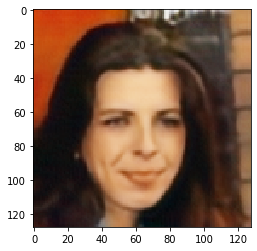

In [267]:
plt.imshow(decoder_predicted[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


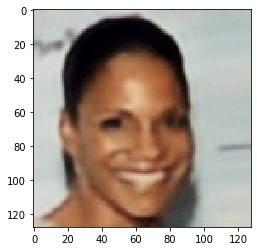

In [49]:
plt.imshow(y_predict[10])

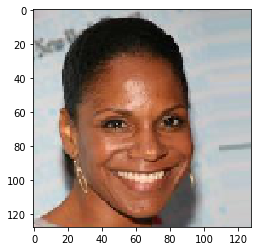

In [50]:
plt.imshow(x_train[10])